<a href="https://colab.research.google.com/github/MatRitchie/Sunshine/blob/main/Sunshine_mat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, homogeneity_completeness_v_measure, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from google.colab import userdata, files
from umap import UMAP
from itertools import combinations
from tqdm import tqdm
import time

# Setup Github access

In [4]:
os.environ['GITHUB_TOKEN'] = userdata.get('GITHUB_TOKEN')

%cd /content
!git clone https://$GITHUB_TOKEN@github.com/MatRitchie/Sunshine.git

%cd /content/Sunshine
!git pull https://$GITHUB_TOKEN@github.com/MatRitchie/Sunshine.git main

/content
Cloning into 'Sunshine'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 242 (delta 108), reused 59 (delta 47), pack-reused 88 (from 1)
Receiving objects: 100% (242/242), 5.08 MiB | 11.75 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/Sunshine
From https://github.com/MatRitchie/Sunshine
 * branch            main       -> FETCH_HEAD
Already up to date.


# Data

In [ ]:
df_all = pd.read_csv("combined_project_status.csv")
retired_graduated_bypassed = df_all.loc[df_all['status'] != 'evolved']

retired_graduated_bypassed.head()

,project,COM-1,COM-2,POP-1,STA-1,STA-2,STA-3,STA-4,STA-5,STA-6,...,SWQ-2.2,SWQ-2.3,SWQ-2.4,SWQ-2.5,SWQ-2.6,SWQ-2.7,init,end,project_url,status
189,abdera,2.938138e+06,608,61,16,286,25,0,2,1,...,40,1,0,2,9.878605,274,2006-06-06,2008-11-08,https://github.com/apache/abdera,graduated
190,airavata,6.952637e+06,1571,324,11,-266,114,0,5,0,...,0,50,95,340,49.897383,323,2011-05-05,2012-09-19,https://github.com/apache/airavata,graduated
191,age,3.819620e+06,590,6087,5,5,401,14,5,0,...,35,2,11,20,15.380107,279,2020-04-29,2022-05-18,https://github.com/apache/age,graduated
192,apisix,9.013296e+05,2035,30442,6,-15,2452,29,5,0,...,41,1,0,12,26.869675,415,2019-10-17,2020-07-15,https://github.com/apache/apisix,graduated
193,accumulo,1.375896e+07,1190,2552,14,-40,444,0,3,0,...,0,10,23,61,19.842345,469,2011-09-12,2012-03-21,https://github.com/apache/accumulo,graduated


##Normalizing the data

In [147]:
scaler = StandardScaler()
df_numeric = retired_graduated_bypassed.select_dtypes(include=[np.number])
df_norm = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
df_norm.head()

,COM-1,COM-2,POP-1,STA-1,STA-2,STA-3,STA-4,STA-5,STA-6,STA-7,...,TEC-3,TEC-4,SWQ-1,SWQ-2.1,SWQ-2.2,SWQ-2.3,SWQ-2.4,SWQ-2.5,SWQ-2.6,SWQ-2.7
0,-0.540349,-0.231303,-0.359820,1.503835,0.928642,-0.345772,-0.172784,-0.404366,1.928292,-0.145164,...,-0.339871,-0.479124,-0.113137,-0.030542,1.471080,-0.431677,-0.360397,-0.331481,-0.512649,-0.183522
1,0.109160,-0.173075,-0.343099,-0.041517,-0.847206,-0.310831,-0.172784,0.400363,-0.518594,0.031458,...,-0.228712,0.302507,-0.144048,-0.611798,-1.057132,4.116447,1.613045,1.891280,2.833377,-0.089302
2,-0.397733,-0.232392,0.023313,-1.895939,0.024633,-0.198159,-0.060375,0.400363,-0.518594,0.325828,...,-0.242814,-0.516210,-0.354121,-0.580818,1.155053,-0.338858,-0.131894,-0.213109,-0.052660,-0.173908
3,-0.869885,-0.145019,1.571802,-1.586868,-0.039710,0.607039,0.060063,0.400363,-0.518594,-0.439533,...,0.542350,-0.409421,-0.364389,-0.554562,1.534285,-0.431677,-0.360397,-0.265718,0.907999,0.087602
4,1.210360,-0.196113,-0.201443,0.885694,-0.120138,-0.181277,-0.172784,-0.136123,-0.518594,-0.086290,...,-0.205070,0.523801,-0.052504,-0.071848,-1.057132,0.403693,0.117383,0.056516,0.320434,0.191437


##Feature selection

In [148]:
status = retired_graduated_bypassed['status']

communication = ['COM-1', 'COM-2']
popularity = ['POP-1']
stability = ['STA-1','STA-2', 'STA-3', 'STA-4', 'STA-5', 'STA-6', 'STA-7', 'STA-8', 'STA-9']
technical_activity = ['TEC-1', 'TEC-2', 'TEC-3', 'TEC-4']
quality = ['SWQ-1', 'SWQ-2.1', 'SWQ-2.2', 'SWQ-2.3', 'SWQ-2.4', 'SWQ-2.5', 'SWQ-2.6', 'SWQ-2.7']

features = quality + stability + technical_activity + communication + popularity
X = df_norm[features]
X.head()

,SWQ-1,SWQ-2.1,SWQ-2.2,SWQ-2.3,SWQ-2.4,SWQ-2.5,SWQ-2.6,SWQ-2.7,STA-1,STA-2,...,STA-7,STA-8,STA-9,TEC-1,TEC-2,TEC-3,TEC-4,COM-1,COM-2,POP-1
0,-0.113137,-0.030542,1.471080,-0.431677,-0.360397,-0.331481,-0.512649,-0.183522,1.503835,0.928642,...,-0.145164,-0.298612,-0.338437,-0.347140,-0.634930,-0.339871,-0.479124,-0.540349,-0.231303,-0.359820
1,-0.144048,-0.611798,-1.057132,4.116447,1.613045,1.891280,2.833377,-0.089302,-0.041517,-0.847206,...,0.031458,-0.328172,-0.354093,0.038330,0.132326,-0.228712,0.302507,0.109160,-0.173075,-0.343099
2,-0.354121,-0.580818,1.155053,-0.338858,-0.131894,-0.213109,-0.052660,-0.173908,-1.895939,0.024633,...,0.325828,-0.296641,-0.244498,-0.146779,1.457445,-0.242814,-0.516210,-0.397733,-0.232392,0.023313
3,-0.364389,-0.554562,1.534285,-0.431677,-0.360397,-0.265718,0.907999,0.087602,-1.586868,-0.039710,...,-0.439533,-0.131105,-0.127074,0.489315,0.925388,0.542350,-0.409421,-0.869885,-0.145019,1.571802
4,-0.052504,-0.071848,-1.057132,0.403693,0.117383,0.056516,0.320434,0.191437,0.885694,-0.120138,...,-0.086290,-0.286788,-0.377578,0.163469,-0.351218,-0.205070,0.523801,1.210360,-0.196113,-0.201443


#Vizualization of data




##t-sne

[t-sne intro](https://www.datacamp.com/tutorial/introduction-t-sne) <br>
[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

>Parameters:
>>Perplexity: how much to focus on local vs global aspect of data. (5-50)low perplexity is more focus on local structure, while higher perplexity focus more in global structure

In [8]:
tsne_2 = TSNE(n_components=2, perplexity=30, random_state=42)
proj_2d = tsne_2.fit_transform(X)
kl = tsne_2.kl_divergence_

fig = px.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], color=status)
fig.update_layout(
    title=f"t-SNE vizualization kl_divergence:{kl}",
    xaxis_title="x",
    yaxis_title="y",
)
fig.show()

In [9]:
tsne_3 = TSNE(n_components=3, perplexity=50, random_state=42)
proj_3d = tsne_3.fit_transform(X)
kl = tsne_3.kl_divergence_


fig = px.scatter_3d(x=proj_3d[:, 0], y=proj_3d[:, 1], z=proj_3d[:, 2], color=status)
fig.update_layout(
    title=f"3D t-SNE vizualization kl_divergence:{kl}",
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="z"
    )
)

fig.show()

##UMAP
Uniform Manifold Approximation and Projection for Dimension Reduction <br>

[Understanding UMAP](https://pair-code.github.io/understanding-umap/) <br>
[Documentation](https://umap-learn.readthedocs.io/en/latest/)

Parameters:
>n_neighbors: determine the size of the local neighborhood, low is local, high is more global. default=15<br>
>min_dist: minimum distance points may have. low values is more clumps, while high is more spread out <br>
>

In [23]:
umap_2d = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
proj_2d = umap_2d.fit_transform(X)

fig = px.scatter(x=proj_2d[:, 0], y=proj_2d[:, 1], color=status)
fig.update_layout(
    title="UMAP vizualization",
    xaxis_title="x",
    yaxis_title="y",
)
fig.show()

def UMAP_2d(data, pred):
    umap_2d = UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
    proj_2d = umap_2d.fit_transform(data)

    df = pd.DataFrame({
        'x': proj_2d[:, 0],
        'y': proj_2d[:, 1],
        'cluster': pred,
        'status': status.astype(str)
    })


    fig = px.scatter(df, x='x', y='y',
                    color=df['cluster'].astype(str),
                    symbol='status',
                    labels={'color': 'Cluster', 'symbol': 'Status'})
    fig.update_layout(
        title="UMAP vizualization",
        xaxis_title="x",
        yaxis_title="y",
    )

    fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [12]:
umap_3d = UMAP(n_neighbors=15, min_dist=0.1, n_components=3)
proj_3d = umap_3d.fit_transform(X)


fig = px.scatter_3d(x=proj_3d[:, 0], y=proj_3d[:, 1], z=proj_3d[:, 2], color=status)
fig.update_layout(
    title="UMAP vizualization",
    scene=dict(
        xaxis_title="x",
        yaxis_title="y",
        zaxis_title="z"
    )
)

fig.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



#Models

##DBScan

###Elbow method

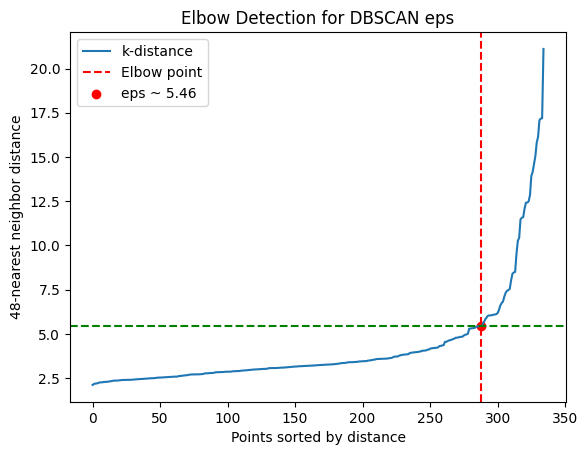

Suggested eps value: 5.4559


In [43]:
min_samples = len(features) * 2

k = min_samples
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

distances = np.sort(distances[:, k-1], axis=0)


def find_elbow(distances):
    n_points = len(distances)
    all_coords = np.vstack((range(n_points), distances)).T
    first_point = all_coords[0]
    last_point = all_coords[-1]

    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_projected = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_projected
    distances_to_line = np.linalg.norm(vec_to_line, axis=1)

    elbow_index = np.argmax(distances_to_line)
    return elbow_index, distances[elbow_index]


elbow_index, elbow_value = find_elbow(distances)


plt.plot(distances, label='k-distance')
plt.axvline(elbow_index, color='r', linestyle='--', label='Elbow point')
plt.axhline(elbow_value, color='g', linestyle='--')
plt.scatter(elbow_index, elbow_value, color='red', label=f'eps ~ {elbow_value:.2f}')
plt.legend()
plt.title('Elbow Detection for DBSCAN eps')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-nearest neighbor distance')
plt.show()

print(f"Suggested eps value: {elbow_value:.4f}")

In [44]:
dbscan = DBSCAN(eps=elbow_value, min_samples=3).fit(X)

y_pred_dbscan = dbscan.labels_

UMAP_2d(X, y_pred_dbscan)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



##KMeans

### Elbow method
Used to determine how many clusters should be used in K-means. <br>

For each cluster Within-Cluster Sum of Squares (wcss) is calculated, which is a measure of how well points are clustered around their centroid. The elbow point is when the graph break and adding more cluster doesnt significantly reduce the wcss score. The elbow point is then the optimal amount of clusters, where adding would be unnesesary and could lead to overfitting and less to not capture the complete variability of the data.

[Explanation](https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/) <br>

[Link to implementation](https://www.comet.com/site/blog/how-to-evaluate-clustering-models-in-python/)

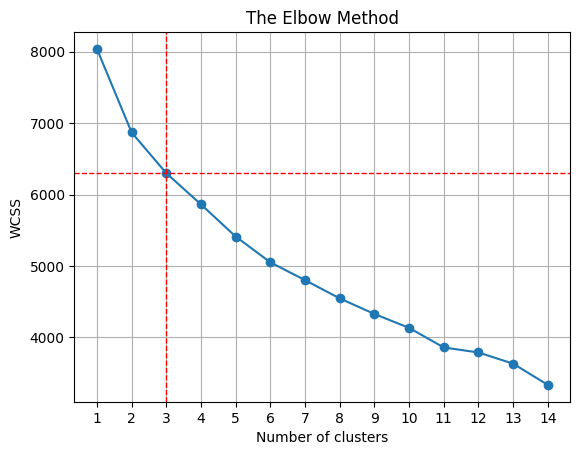

In [ ]:

def find_optimal_clusters(X, create_plot=True, max_clusters=15):

    wcss = []
    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    optimal_clusters = 2 
    for i in range(1, len(wcss) - 1):
        if (wcss[i-1] - wcss[i] > 0.1 * (wcss[0] - wcss[-1])) and (wcss[i] - wcss[i+1] < 0.1 * (wcss[0] - wcss[-1])):
            optimal_clusters = i + 1
            break
    else:
        # If no clear elbow, give 2 clusters as default
        optimal_clusters = 2

    if(create_plot):
        plt.plot(range(1, max_clusters), wcss, marker='o')
        plt.title('The Elbow Method')
        plt.xlabel('Number of clusters')
        plt.ylabel('WCSS')
        plt.xticks(range(1, max_clusters))
        plt.grid(True)

        # Adding red lines that mark optimal number of clusters
        plt.axvline(x=optimal_clusters, color='red', linestyle='--', linewidth=1)
        plt.axhline(y=wcss[optimal_clusters - 1], color='red', linestyle='--', linewidth=1)

        plt.show()

    return optimal_clusters

number_clusters = find_optimal_clusters(X)

##Training

In [150]:
Kmeans = KMeans(n_clusters=number_clusters)
Kmeans.fit(X)
y_pred_kmeans = Kmeans.labels_

UMAP_2d(X, y_pred_kmeans)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



#Evaluation of clustering algorithms

Evaluation of clusters is done by different metrics of combining cohesion within a cluster and seperation between clusters.

* Internal cluster validation
  * Evaluation based on the clusters themselves
* External cluster validation
  * Evaluating of clusters with external labels eg. graduated/retired
* Relative cluster validation
  *  Evaluation results by variyng different parameters of the models


##Internal validation

###Silhuette score

The silhuette score for a sample is given as: <br>
s = a - b / max(a, b) <br>

a = mean distance between sample and all other points in cluster <br>
b = mean distance bewteen sample and all other in next nearest cluster <br>

The Silhuette Coefficient for a set sample is then the mean of the coefficient for each sample in the set. <br>

-1 is an incorrect cluster, 1 is highly dense, and around 0 indicates overlapping clusters.


[Documentation](https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)

### Calinski Harabaz Index (Variance Ratio Criterion)

A hihger score indicates a model with better defined clusters. Assesment of how well seperated and compact clusters are. Ther isn't a upper level to the index.

Index = ratio of between-clusters dispersion and within-cluster dispersion

between-cluster dispersion = how well **seperated** clusters are

within-cluster dispersion = measures the **compactness** of each cluster

[Documentation](https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index)

###Davies Bouldin index

Lower index (0 is lowest possible score) = better seperation between clusters

Index = average similarity between clusters

Similarity compares the distance between clusters with the size of the clusters



[Documentation](https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index)

###Comparison of internal metrics for different models

In [83]:

models = [
    ("KMeans", y_pred_kmeans),
    ("DBSCAN", y_pred_dbscan),
    ("Labels", status)
]

def compare_models(data, models):
  results = []

  for name, y_pred in models:
    score_db = davies_bouldin_score(data, y_pred)
    score_sil = silhouette_score(data, y_pred)
    score_ch = calinski_harabasz_score(data, y_pred)

    results.append({
            "Model": name,
            "Silhouette": score_sil,
            "Davies-Bouldin": score_db,
            "Calinski-Harabasz": score_ch
      })

  return pd.DataFrame(results).sort_values(by="Silhouette", ascending=False)

compare_models(X, models)

,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.322219,1.068732,129.176585
1,DBSCAN,0.249332,6.992381,2.165186
2,Labels,-0.041514,10.624958,2.205101


##External validation

We want to identity inconsistencies between (retired/graduated) labels and clusters

###Homogeneity and completeness

* homogeneity: each cluster contains only members of a single class.

* completeness: all members of a given class are assigned to the same cluster.

1 = perfect score, 0 = bad

[Source](https://scikit-learn.org/stable/modules/clustering.html#homogeneity-completeness-and-v-measure)

In [144]:
score_kmeans =homogeneity_completeness_v_measure(status, y_pred_kmeans)
score_db = homogeneity_completeness_v_measure(status, y_pred_dbscan)

print("KMeans: ", score_kmeans)
print("DBSCAN: ", score_db)

KMeans:  (np.float64(0.004468293774427729), np.float64(0.0039060903365795143), np.float64(0.004168320655449682))
DBSCAN:  (np.float64(0.004104346884208348), np.float64(0.015259529482513433), np.float64(0.006468787664196648))


##Classification with the clustering labels

<ipython-input-151-1eec8d364749>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




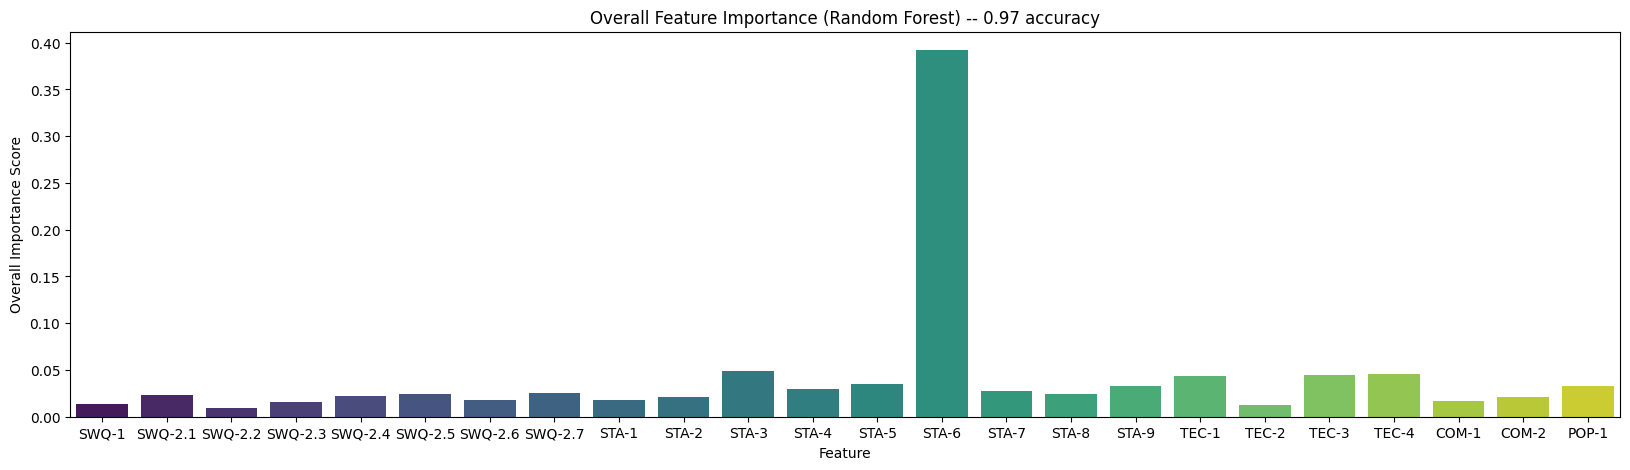

array([0.01394907, 0.02286974, 0.00959696, 0.01626146, 0.0223652 ,
       0.02476087, 0.01825368, 0.02535666, 0.01760027, 0.0215329 ,
       0.04932237, 0.0296086 , 0.03452567, 0.39207093, 0.02773556,
       0.02377317, 0.03244695, 0.0439091 , 0.01246286, 0.04459424,
       0.04531919, 0.01707849, 0.02152208, 0.03308397])

In [151]:

def overall_feature_importance(X, y_clusters, features, create_plot=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y_clusters, test_size=0.2, random_state=42)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    rf_pred = rf.predict(X_test)
    overall_importance = rf.feature_importances_

    accuracy = accuracy_score(y_test, rf_pred)


    if(create_plot):
      plt.figure(figsize=(20, 5))
      sns.barplot(x=features, y=overall_importance, palette="viridis")
      plt.xlabel("Feature")
      plt.ylabel("Overall Importance Score")
      plt.title(f"Overall Feature Importance (Random Forest) -- {accuracy:.2f} accuracy")
      plt.show()

    return overall_importance

overall_feature_importance(X, y_pred_kmeans, features)

###Most importent feature for each cluster using classification

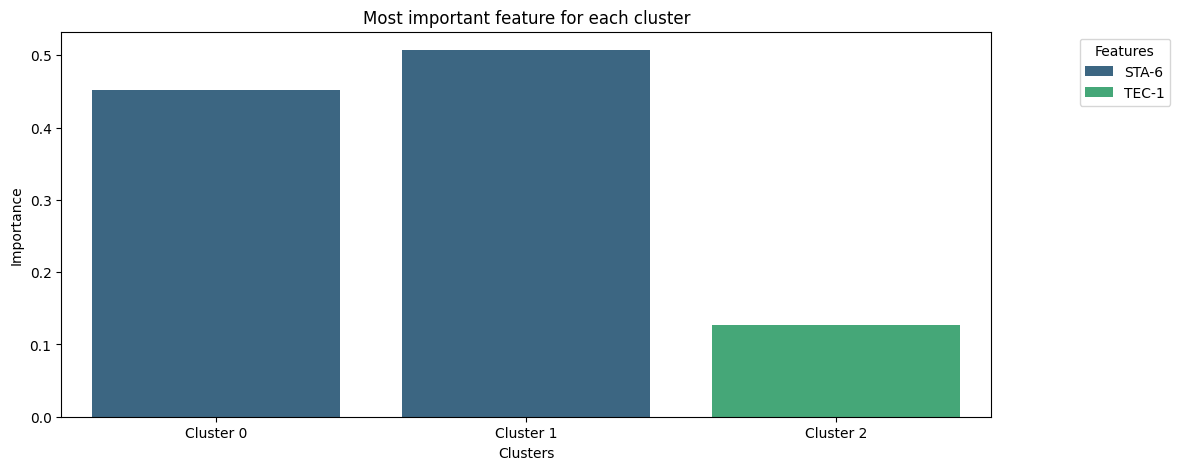

In [ ]:

def feature_importance_each_cluster(X, y_clusters, features,create_plot=True):
    #binary classification on each cluster
    cluster_importance = []
    for cluster in range(number_clusters):
        binary_target = (y_clusters == cluster) 
        rf_cluster = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_cluster.fit(X, binary_target)
        cluster_importance.append(rf_cluster.feature_importances_)


    #get most importent featre for each cluster
    most_important_feature_idx = np.argmax(cluster_importance, axis=1)
    most_important_feature = [features[idx] for idx in most_important_feature_idx]
    max_importance_values = np.max(cluster_importance, axis=1)
    clusters = [f"Cluster {i}" for i in range(number_clusters)]

    if(create_plot):
      #most importent feature for each cluster
      plt.figure(figsize=(12, 5))
      sns.barplot(x=clusters, y=max_importance_values, hue=most_important_feature, palette="viridis")
      plt.xlabel("Clusters")
      plt.ylabel("Importance")
      plt.title("Most important feature for each cluster")
      plt.legend(title="Features", bbox_to_anchor=(1.2, 1), loc='upper right')
      plt.show()

feature_importance_each_cluster(X, y_pred_kmeans, features)

##Status distribution in each cluster

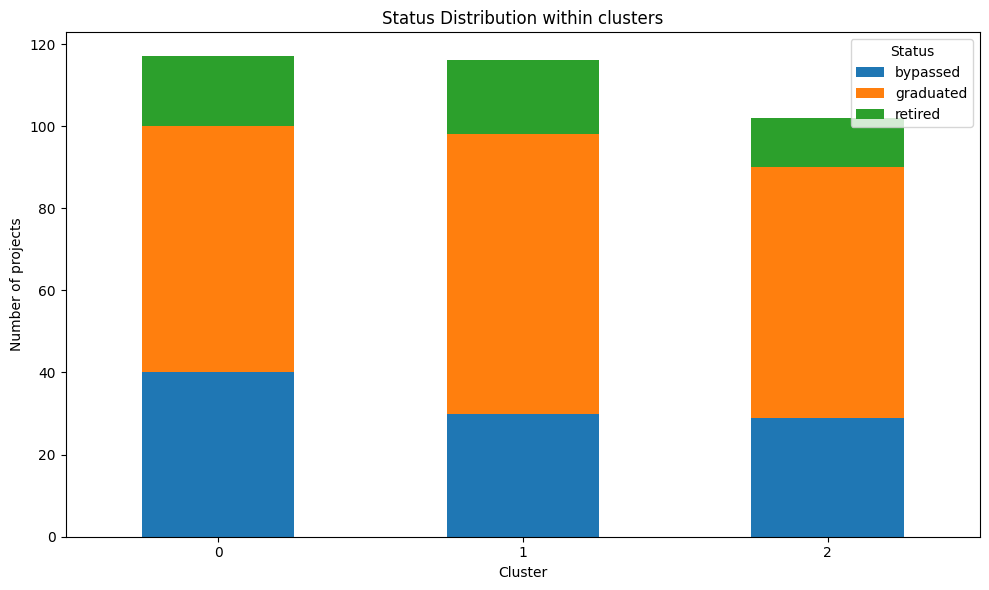

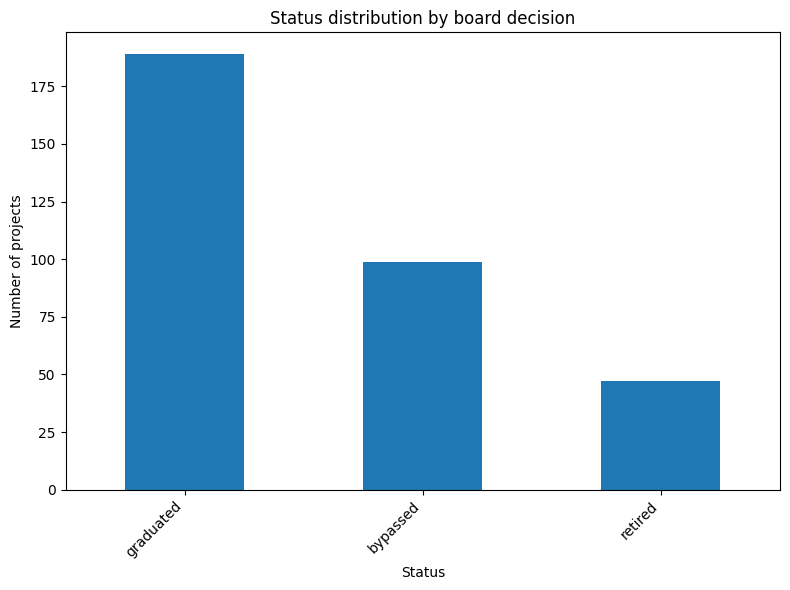

In [91]:
def get_status_distribution(labels,  status_column=status):

    df = pd.DataFrame({
        'cluster': labels,
        'status': status_column
    })

    return df.groupby(['cluster', 'status']).size().unstack(fill_value=0)


status_distribution = get_status_distribution(y_pred_kmeans)
status_distribution = get_status_distribution(y_pred_dbscan)


status_distribution.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Status Distribution within clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of projects')
plt.xticks(rotation=0)
plt.legend(title='Status')
plt.tight_layout()
plt.show()

status_counts = status.value_counts()

status_counts.plot(kind='bar', figsize=(8, 6))
plt.title('Status distribution by board decision')
plt.xlabel('Status')
plt.ylabel('Number of projects')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
def create_labels_as_clusters_df(status):
    status_counts = status.value_counts()
    unique_statuses = status_counts.index.tolist()

    overall_as_clusters_data = {}
    for status in unique_statuses:
        row = {}
        for other_status in unique_statuses:
            if status == other_status:
                row[other_status] = status_counts[status]
            else:
                row[other_status] = 0
        overall_as_clusters_data[status] = row

    overall_as_clusters_df = pd.DataFrame.from_dict(overall_as_clusters_data, orient='index')
    overall_as_clusters_df.index.name = 'cluster'

    return overall_as_clusters_df


def compute_overall_status_distribution(df):
    total_counts = df.sum(axis=0)  # sum over clusters
    total_sum = total_counts.sum()

    if total_sum == 0:
        return pd.Series(0, index=total_counts.index, dtype=float)

    return total_counts / total_sum


def get_absolute_difference(df1, df2):
    diff = np.abs(df1.to_numpy() - df2.to_numpy())
    total_diff = diff.sum()

    return total_diff

In [ ]:

all_features = list(X.columns)
n_features = 10
best_tvd = float('inf')
best_features = None
processed_combinations = set()
label_as_cluster_distribution = create_labels_as_clusters_df(status)

n_clusters = 3

total_combinations = sum(len(list(combinations(all_features, k))) for k in range(2, n_features + 1))


combinations_processed = 0
start_time = time.time()

print(f"Total number of feature combinations to process: {total_combinations}")

with tqdm(total=total_combinations, desc="Processing Feature Combinations") as pbar:
    for k in range(2, n_features + 1):
        for feature_subset in combinations(all_features, k):
            X_subset = X[list(feature_subset)]

            # Cluster
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=300, tol=1e-4)
            cluster_labels = kmeans.fit_predict(X_subset)

            # Evaluate
            status_dist = get_status_distribution(cluster_labels)
            overall_tvd = get_absolute_difference(status_dist, label_as_cluster_distribution )

            if overall_tvd < best_tvd:
                best_tvd = overall_tvd
                best_features = list(feature_subset)
                tqdm.write(f"New Best -> Features: {best_features}, TVD: {best_tvd:.4f}")

            # Update progress
            pbar.update(1)

elapsed_time = time.time() - start_time
print("\n\nBest Feature Subset:")
print(f"Features: {best_features}, absolute diff: {best_tvd:.4f}, Time Elapsed: {elapsed_time:.2f}s")


Total number of feature combinations to process: 4540361


Processing Feature Combinations:   0%|          | 5/4540361 [00:00<29:23:32, 42.91it/s]

New Best -> Features: ['SWQ-1', 'SWQ-2.1'], TVD: 470.0000
New Best -> Features: ['SWQ-1', 'SWQ-2.2'], TVD: 382.0000


Processing Feature Combinations:   0%|          | 7/4540361 [00:00<29:23:32, 42.91it/s]

New Best -> Features: ['SWQ-1', 'STA-1'], TVD: 350.0000


Processing Feature Combinations:   0%|          | 419/4540361 [00:11<31:57:04, 39.47it/s]

New Best -> Features: ['SWQ-1', 'STA-1', 'STA-5'], TVD: 346.0000


Processing Feature Combinations:   0%|          | 1804/4540361 [00:45<29:28:08, 42.78it/s]

New Best -> Features: ['STA-1', 'STA-6', 'COM-1'], TVD: 344.0000


Processing Feature Combinations:   0%|          | 3404/4540361 [01:15<22:58:24, 54.86it/s]

New Best -> Features: ['SWQ-1', 'SWQ-2.7', 'STA-1', 'STA-8'], TVD: 340.0000


Processing Feature Combinations:   0%|          | 18922/4540361 [07:34<24:49:59, 50.58it/s]

New Best -> Features: ['SWQ-1', 'SWQ-2.6', 'STA-1', 'STA-8', 'COM-1'], TVD: 336.0000


Processing Feature Combinations:   1%|          | 27460/4540361 [10:22<23:08:23, 54.17it/s]

New Best -> Features: ['SWQ-2.1', 'STA-1', 'STA-4', 'STA-5', 'COM-1'], TVD: 332.0000


Processing Feature Combinations:   4%|▍         | 183776/4540361 [1:02:29<23:35:20, 51.30it/s]

New Best -> Features: ['STA-1', 'STA-4', 'STA-5', 'STA-6', 'TEC-2', 'COM-1'], TVD: 326.0000


Processing Feature Combinations:   7%|▋         | 306400/4540361 [1:43:47<23:54:17, 49.20it/s]


KeyboardInterrupt: 

# Outlier Detection

[Scikit learn - Outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html)

## Isolation Forest

[Isolation forest example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py)<br>
[Isolation forest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest)

In [ ]:


model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
df_all_Wo_Nan = df_all.dropna().select_dtypes(include=np.number)
model.fit(df_all_Wo_Nan)

outliers = model.predict(df_all.select_dtypes(include=np.number).fillna(df_all.select_dtypes(include=np.number).mean()))

df_all['outlier'] = outliers

fig = px.scatter(df_all, x='STA-1', y='COM-1', color='outlier',
                 title="Outlier Visualization with Isolation Forest",
                 labels={'STA-1': 'Projects Age', 'COM-1': 'COM-1 Metric'},
                 color_discrete_map={-1: 'red', 1: 'blue'})
fig.show()

In [ ]:
print(len(df_all[outliers == -1]))

25


## Local Outlier Factor

[LOF example](https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py)<br>
[LOF documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor)

In [ ]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(df_all_Wo_Nan)
X_scores = clf.negative_outlier_factor_

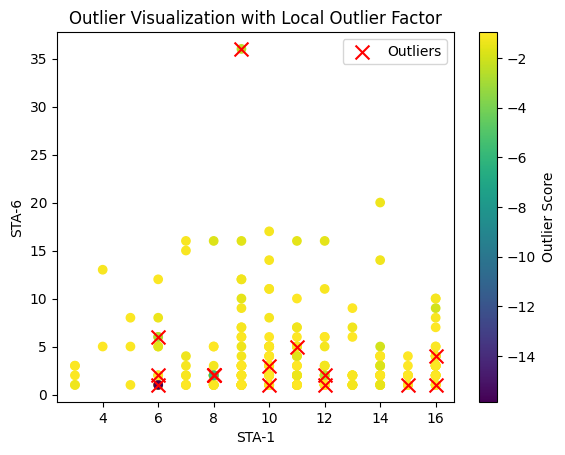

In [ ]:

# Plot the data points with outlier score colored
plt.scatter(df_all_Wo_Nan.iloc[:, 0], df_all_Wo_Nan.iloc[:, 1], c=X_scores, cmap='viridis')
plt.colorbar(label='Outlier Score')

# Highlight outliers
outlier_indices = X_scores < -2
plt.scatter(df_all_Wo_Nan.iloc[outlier_indices, 0], df_all_Wo_Nan.iloc[outlier_indices, 1],
            marker='x', color='red', s=100, label='Outliers')

plt.xlabel(df_all_Wo_Nan.columns[0])
plt.ylabel(df_all_Wo_Nan.columns[1])
plt.title('Outlier Visualization with Local Outlier Factor')
plt.legend()
plt.show()

In [ ]:
print(df_all[df_all['STA-6']>30])

   project               COM-1 COM-3  POP-4  STA-1 STA-2 STA-4 STA-5  STA-6  \
17    beam  11782722.634169074  4666  19564    9.0   116  4198   415     36   

    STA-7  ... SWQ-4.4 SWQ-4.5    SWQ-4.6 SWQ-4.7        init         end  \
17  False  ...      79     149  12.888702    2003  2016-02-01  2016-12-21   

   frequency (weeks)                     project_url     status  outlier  
17                12  https://github.com/apache/beam  graduated       -1  

[1 rows x 32 columns]
